# EDA on the MIND Dataset

The dataset used in this project can be found on Kaggle: [MIND: Microsoft News Recommendation Dataset](https://www.kaggle.com/datasets/arashnic/mind-news-dataset)

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
col_names = ["impression_id", "user_id", "time", "history", "impressions"]
behaviors = pd.read_csv("behaviors.tsv", sep="\t", names=col_names, quoting=3)

col_names = ["id", "category", "subcategory", "title", "abstract", "link", "title_entities", "abstract_entities"]
news = pd.read_csv("news.tsv", sep="\t", names=col_names, quoting=3)


def load_vec_file(path):
    embeddings = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) <= 2:
                continue
            key = parts[0]
            vec = np.array(list(map(float, parts[1:])))
            embeddings[key] = vec
    return embeddings

entity_embeddings = load_vec_file("entity_embedding.vec")
relation_embeddings = load_vec_file("relation_embedding.vec")

# News and behaviors

In [72]:
behaviors.head()

,impression_id,user_id,time,history,impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


In [73]:
news.head()

,id,category,subcategory,title,abstract,link,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


First let's remove missing values and unused columns

In [74]:
print(news.isnull().sum())
print("Total missing:", news.isnull().sum().sum())

id                      0
category                0
subcategory             0
title                   0
abstract             2666
link                    0
title_entities          0
abstract_entities       0
dtype: int64
Total missing: 2666


In [81]:
news = news.dropna(subset=['abstract'])

columns_to_drop = ['category', 'subcategory', 'title_entities', 'abstract_entities']
news = news.drop(columns=columns_to_drop, errors='ignore')

print(news.isnull().sum())
print("Total missing:", news.isnull().sum().sum())

id          0
title       0
abstract    0
link        0
dtype: int64
Total missing: 0


In [76]:
print(behaviors.isnull().sum())
print("Total missing:", behaviors.isnull().sum().sum())

impression_id       0
user_id             0
time                0
history          3238
impressions         0
dtype: int64
Total missing: 3238


In [77]:
behaviors = behaviors.dropna(subset=['history'])
print(behaviors.isnull().sum())
print("Total missing:", behaviors.isnull().sum().sum())

impression_id    0
user_id          0
time             0
history          0
impressions      0
dtype: int64
Total missing: 0


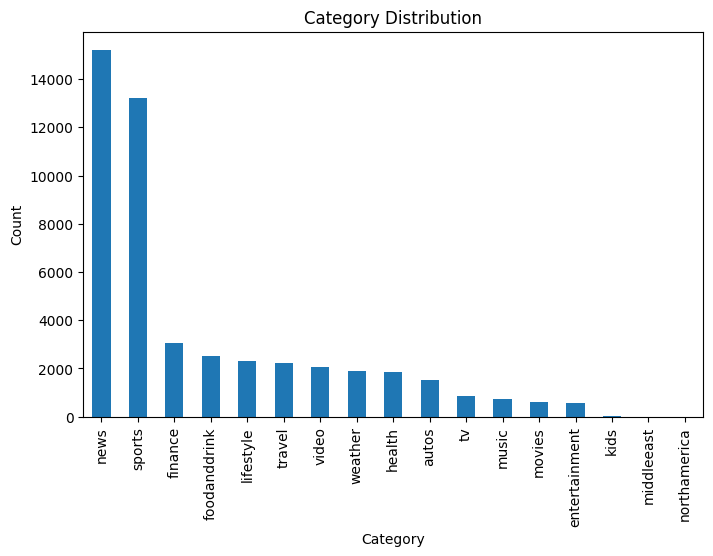

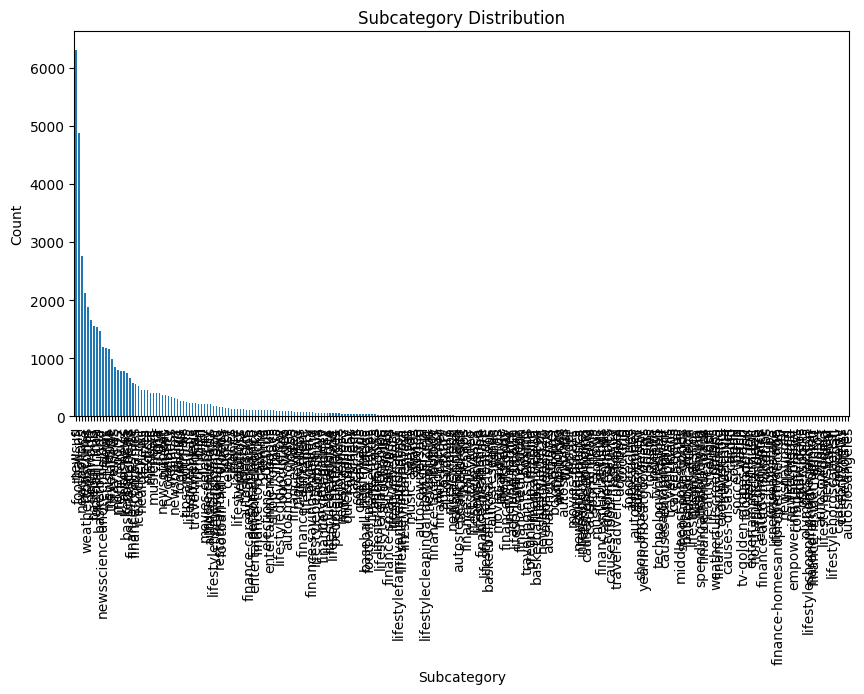

In [78]:
plt.figure(figsize=(8, 5))
news['category'].value_counts().plot(kind='bar')
plt.title("Category Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

# Plot subcategory distribution
plt.figure(figsize=(10, 5))
news['subcategory'].value_counts().plot(kind='bar')
plt.title("Subcategory Distribution")
plt.xlabel("Subcategory")
plt.ylabel("Count")
plt.show()

As we can see there is a huge imbalance over the category, therefore we will only be using the author and the abstract for our content based models.

In [86]:
behaviors['time'] = pd.to_datetime(behaviors['time'], format='%m/%d/%Y %I:%M:%S %p')

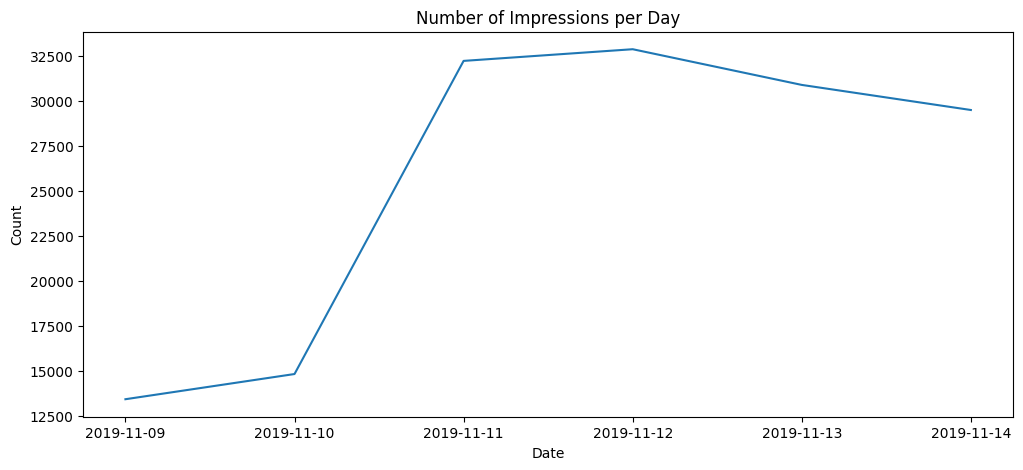

In [87]:
behaviors['date'] = behaviors['time'].dt.date
behaviors['hour'] = behaviors['time'].dt.hour
behaviors['day_of_week'] = behaviors['time'].dt.day_name()

# 1. Activity over time (by day)
daily_activity = behaviors.groupby('date').size()
plt.figure(figsize=(12,5))
daily_activity.plot()
plt.title('Number of Impressions per Day')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()

/var/folders/pg/1l4d75p90r565jztmcw4v8c00000gn/T/ipykernel_34373/4190394435.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_activity.index, y=hourly_activity.values, palette="viridis")


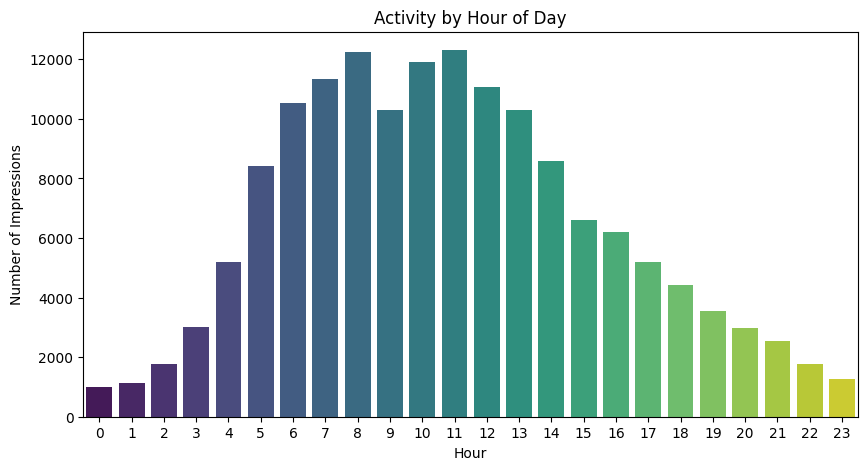

In [88]:
# 2. Activity by hour of day
hourly_activity = behaviors.groupby('hour').size()
plt.figure(figsize=(10,5))
sns.barplot(x=hourly_activity.index, y=hourly_activity.values, palette="viridis")
plt.title('Activity by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Impressions')
plt.show()

/var/folders/pg/1l4d75p90r565jztmcw4v8c00000gn/T/ipykernel_34373/3826240028.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dow_activity.index, y=dow_activity.values, palette="magma")


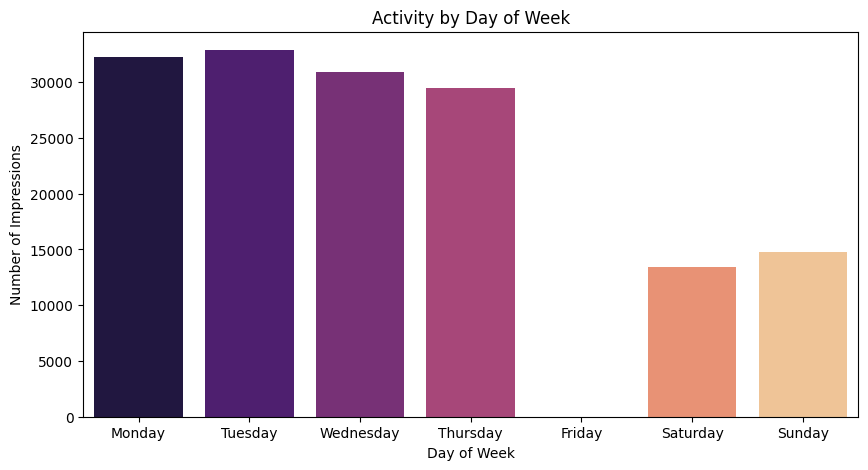

In [89]:
# 3. Activity by day of the week
dow_activity = behaviors.groupby('day_of_week').size()
# Ensure correct order
dow_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dow_activity = dow_activity.reindex(dow_order)
plt.figure(figsize=(10,5))
sns.barplot(x=dow_activity.index, y=dow_activity.values, palette="magma")
plt.title('Activity by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Impressions')
plt.show()